In [1]:
import sys
import os

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict
from effdet.efficientdet import HeadNet

In [2]:
import torch
for i in range (torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
if torch.cuda.device_count() > 1:
    torch.cuda.set_device(1)
    print("select", torch.cuda.get_device_name(torch.cuda.current_device()))

GeForce GTX 1080 Ti
GeForce GTX 1070
select GeForce GTX 1070


In [3]:
image_scale = 768

In [4]:
def get_valid_transforms():
    return A.Compose([
            #A.ToGray(p=1.0),
            #A.ChannelShuffle(p=1.0),
            A.Resize(height=image_scale, width=image_scale, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

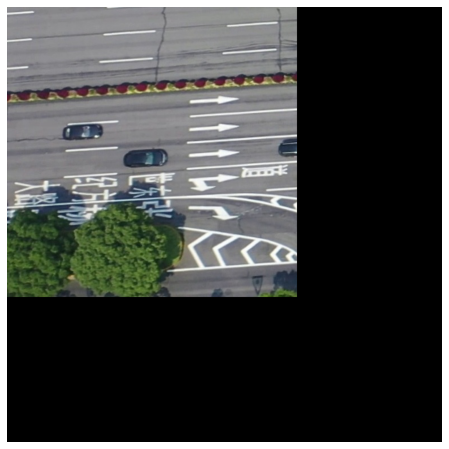

In [5]:
class DatasetRetriever(Dataset):
    def __init__(self, root, transform=None):
        super(DatasetRetriever, self).__init__()
        if isinstance(root, torch._six.string_classes):
            root = os.path.expanduser(root)
        self.root = root
        self.transform = transform
        self.img_names = []
        for item in os.listdir(root):
            pos = item.rfind(".")
            if pos != -1:
                ext = item[pos+1:]
                if ext in ("jpg", "JPG", "jpeg", "JPEG", "png", "PNG"):
                    self.img_names.append(item)
        self.img_ids = list(range(len(self.img_names)))

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        path = os.path.join(self.root,  self.img_names[index])
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        crop_img = np.zeros((image_scale, image_scale,3), np.float32)
        if image.shape[0] <= image_scale and image.shape[1] < image_scale:
            crop_img[0:image.shape[0], 0:image.shape[1]] = image
        else:
            crop_img = cv2.resize(image, (crop_img.shape[1], crop_img.shape[0]))

        if self.transform:
            sample = {'image': crop_img}
            sample = self.transform(**sample)
            crop_img = sample['image']

        return crop_img, img_id

    def __len__(self):
        return len(self.img_ids)
        
    def get_img(self, index):
        img_id = self.img_ids[index]
        path = os.path.join(self.root,  self.img_names[index])
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

d = DatasetRetriever("_datasets/test")
#fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#ax.imshow(d.get_img(0))       
for i, (img, img_id) in enumerate(d):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.set_axis_off()
    ax.imshow(img);
    break

In [6]:
dataset = DatasetRetriever("_datasets/test", transform=get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [19]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d2')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = image_scale
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchPredict(net, config)
    net.eval();
    return net.cuda()

net = []
#net.append(load_net('_models/effdet-d2-drone_000_512_bs4_epoch3/best-checkpoint-002epoch.bin')) # 0.13117 *
#net.append(load_net('_models/effdet-d2-drone_003_512_1024_bs8_epoch32/best-checkpoint-005epoch.bin')) # 0.08557 *
#net.append(load_net('_models/effdet-d3-drone_004_896_1792_bs2_epoch6/best-checkpoint-000epoch.bin'))
#net.append(load_net('_models/effdet-d3-drone_004_896_1792_bs2_epoch6/best-checkpoint-004epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_005_768_1536_bs4_epoch6/best-checkpoint-000epoch.bin')) # 0.12632
#net.append(load_net('_models/effdet-d2-drone_005_768_1536_bs4_epoch6/best-checkpoint-002epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_005_768_1536_bs4_epoch6/best-checkpoint-005epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_006_768_1536_rotated_obb_no_cutout_bs2_epoch3/best-checkpoint-000epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_006_768_1536_rotated_obb_no_cutout_bs2_epoch3/best-checkpoint-002epoch.bin')) # 0.09970
#net.append(load_net('_models/effdet-d2-drone_007_768_1536_rotated_obb_no_cutout_more_bus_bs4_epoch4/best-checkpoint-000epoch.bin'))
net.append(load_net('_models/effdet-d2-drone_007_768_1536_rotated_obb_no_cutout_more_bus_bs4_epoch4/best-checkpoint-003epoch.bin')) # 0.08611 *
#net.append(load_net('_models/effdet-d2-drone_010_768_1536_rotated_obb_no_cutout_more_bus_tongji_bs4_epoch16/best-checkpoint-002epoch.bin')) # 0.10132
#net.append(load_net('_models/effdet-d2-drone_010_768_1536_rotated_obb_no_cutout_more_bus_tongji_bs4_epoch16/best-checkpoint-005epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_010_768_1536_rotated_obb_no_cutout_more_bus_tongji_bs4_epoch16/best-checkpoint-015epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_011_768_1536_rotated_obb_no_cutout_tongji_only_bs4_epoch6/best-checkpoint-000epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_011_768_1536_rotated_obb_no_cutout_tongji_only_bs4_epoch6/best-checkpoint-002epoch.bin'))
#net.append(load_net('_models/effdet-d2-drone_011_768_1536_rotated_obb_no_cutout_tongji_only_bs4_epoch6/best-checkpoint-005epoch.bin')) # 0.14645

#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-000epoch.bin')) # 0.27723
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-001epoch.bin')) # 0.13247
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-002epoch.bin')) # 0.09903
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-003epoch.bin')) # 0.09306 *
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-004epoch.bin')) # 0.08728
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-005epoch.bin')) # 0.07890
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-007epoch.bin')) # 0.07537
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-008epoch.bin')) # 0.07197
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-009epoch.bin')) # 0.07010
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-010epoch.bin')) # 0.06595
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-011epoch.bin')) # 0.06282
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-012epoch.bin')) # 0.06200
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-013epoch.bin')) # 0.06004
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-014epoch.bin')) # 0.05823
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-015epoch.bin')) # 0.05920
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-016epoch.bin')) # 0.05726
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-017epoch.bin')) # 0.05400
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-018epoch.bin')) # 0.05455
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-019epoch.bin')) # 0.05458
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-020epoch.bin')) # 0.04762
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-021epoch.bin')) # 0.04812
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-022epoch.bin')) # 0.04714
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-023epoch.bin')) # 0.04563
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-024epoch.bin')) # 0.04516
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-025epoch.bin')) # 0.04450
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-026epoch.bin')) # 0.04439
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-027epoch.bin')) # 0.04366
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-028epoch.bin')) # 0.04301
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-029epoch.bin')) # 0.04282
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-030epoch.bin')) # 0.04277
#net.append(load_net('_models/effdet-d2-drone_012_768_1536_rotated_obb_no_cutout_more_bus_tong_more_color_gray_blur_aug_lr1e-4_bs4_epoch32/best-checkpoint-031epoch.bin')) # 0.04275

#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-000epoch.bin')) # 0.17172
net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-001epoch.bin')) # 0.11777 *
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-002epoch.bin')) # 0.10857
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-003epoch.bin')) # 0.09898
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-004epoch.bin')) # 0.08878
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-005epoch.bin')) # 0.08614
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-006epoch.bin')) # 0.08212
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-007epoch.bin')) # 0.07968 #
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-008epoch.bin')) # 0.07561
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-009epoch.bin')) # 0.07322
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-010epoch.bin')) # 0.07030
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-011epoch.bin')) # 0.06951
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-012epoch.bin')) # 0.06651
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-013epoch.bin')) # 0.06442
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-016epoch.bin')) # 0.05659
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-017epoch.bin')) # 0.05518
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-018epoch.bin')) # 0.05425
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-019epoch.bin')) # 0.05390
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-020epoch.bin')) # 0.05284
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-021epoch.bin')) # 0.05253
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-022epoch.bin')) # 0.05212
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-023epoch.bin')) # 0.05087
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-025epoch.bin')) # 0.04999
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-026epoch.bin')) # 0.04918
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-029epoch.bin')) # 0.04539
#net.append(load_net('_models/effdet-d2-drone_013_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_lr1e-4_bs4_epoch32/best-checkpoint-031epoch.bin')) # 0.04468

net.append(load_net('_models/effdet-d2-drone_014_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_onecyclelr7e-4_bs4_epoch6/best-checkpoint-000epoch.bin')) # 0.08063
#net.append(load_net('_models/effdet-d2-drone_014_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_onecyclelr7e-4_bs4_epoch6/best-checkpoint-001epoch.bin')) # 0.08063
#net.append(load_net('_models/effdet-d2-drone_014_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_onecyclelr7e-4_bs4_epoch6/best-checkpoint-002epoch.bin')) # 0.08063
#net.append(load_net('_models/effdet-d2-drone_014_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_onecyclelr7e-4_bs4_epoch6/best-checkpoint-003epoch.bin')) # 0.08063
#net.append(load_net('_models/effdet-d2-drone_014_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_onecyclelr7e-4_bs4_epoch6/best-checkpoint-004epoch.bin')) # 0.08063
#net.append(load_net('_models/effdet-d2-drone_014_768_1536_rotated_obb_no_cutout_more_bus_tong_changtai_jinqiao_colorjitter0.2_onecyclelr7e-4_bs4_epoch6/best-checkpoint-005epoch.bin')) # 0.08063


In [20]:
def make_predictions(images, net, score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        img_scale = torch.tensor([1]*images.shape[0]).float().cuda()
        img_size = [image.shape[-2:] for image in images]
        img_size = torch.tensor(img_size).float().cuda()
        det = net(images, img_scale, img_size)
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

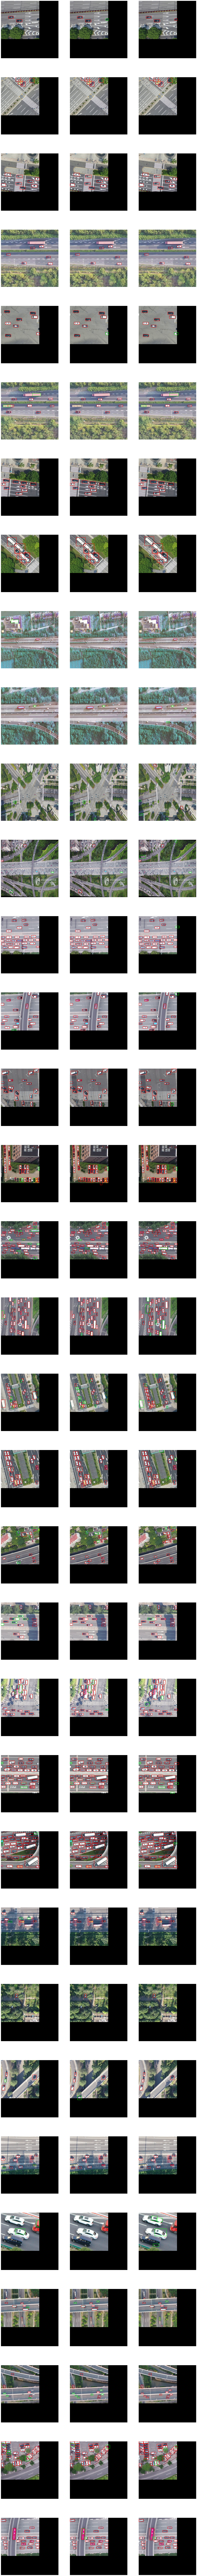

In [21]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

count = 0
max_col = len(net)
max_row = len(dataset)
f, ax = plt.subplots(max_row, max_col, figsize=(25,10*max_row))
        
for j, (images, image_ids) in enumerate(data_loader):
    predictions = []
    for n in net:
        predictions.append(make_predictions(images, n))
    for i, sample in enumerate(images):
        sample = sample.permute(1,2,0).cpu().numpy()
        samples = []
        for k in range(len(net)):
            samples.append(sample.copy())

            boxes, scores, labels = run_wbf(predictions[k], image_index=i, image_size=image_scale)
            boxes = boxes.astype(np.int32).clip(min=0, max=image_scale-1)
            for kk, box in enumerate(boxes):
                c = (1, 0, 0)         #    red: (0.7, 1.0)
                if scores[kk] < 0.5:  # yellow: (0.0, 0.5)
                    c = (1, 1, 0)      # green: (0.5, 0.7)
                if scores[kk] < 0.7:
                    c = (0, 1, 0)
                cv2.rectangle(samples[k], (box[0], box[1]), (box[2], box[3]), c, 2)
            ax[count, k].imshow(samples[k])
            ax[count, k].set_axis_off()

        count += 1
    #if j == 3:
    #    break

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

dpi = matplotlib.rcParams['figure.dpi']*0.65
for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images)
    for i, sample in enumerate(images):
        sample = sample.permute(1,2,0).cpu().numpy()

        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=511)

        fig, ax = plt.subplots(1, 1, figsize=(512.0/dpi, 512.0/dpi))

        for box in boxes:
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

        ax.set_axis_off()
        ax.imshow(sample)

In [ ]:
import matplotlib.pyplot as plt

count = 0
max_col = 2
max_row = (len(dataset) + max_col - 1) // max_col
f, ax = plt.subplots(max_row, max_col, figsize=(20,150))
curr_row = 0
        
for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images)
    for i, sample in enumerate(images):
        sample = sample.permute(1,2,0).cpu().numpy()

        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=511)


        for box in boxes:
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)
        col = count % max_col
        ax[curr_row, col].imshow(sample)
        ax[curr_row, col].set_axis_off()
        if col == max_col - 1:
            curr_row += 1
        count += 1
    #if j == 3:
    #    break

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

dpi = matplotlib.rcParams['figure.dpi']*0.65
for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images)
    for i, sample in enumerate(images):
        sample = sample.permute(1,2,0).cpu().numpy()

        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=511)

        fig, ax = plt.subplots(1, 1, figsize=(512.0/dpi, 512.0/dpi))

        for box in boxes:
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

        ax.set_axis_off()
        ax.imshow(sample)